# Water Quality Management using Deep Clustering
#### Identifying pollution sources by clustering water bodies based on contamination levels, chemical compositions

In [34]:
pip install pyspark

In [35]:
import pandas as pd
import numpy as np

import pyspark
from pyspark.sql import SparkSession # creating spark session

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from keras.models import Model, Sequential
from keras.layers import Dense, Input

import matplotlib.pyplot as plt
import seaborn as sns

In [36]:
np.random.seed(42)
n_watersamples = 500

# our features: pH, Dissolved Oxygen (DO), Nitrate (NO3-), Total Dissolved Solids (TDS), Turbidity
pH = np.random.uniform(6.0, 9.0, n_watersamples)  # pH normally ranges between 6 and 9
DO = np.random.uniform(3.0, 12.0, n_watersamples)  # dissolved oxygen in mg/L (higher is better)
Nitrate = np.random.uniform(0.5, 50.0, n_watersamples)  # nitrate in mg/L (lower is better, means less pollution)
TDS = np.random.uniform(100, 1500, n_watersamples)  # TDS in mg/L
Turbidity = np.random.uniform(0.5, 100.0, n_watersamples) # units: NTU. higher means more cloudy
pH[:5], DO[:5], Nitrate[:5], TDS[:5], Turbidity[:5]

(array([7.12362036, 8.85214292, 8.19598183, 7.79597545, 6.46805592]),
 array([ 9.28345543,  7.8248673 ,  5.78574855, 10.32415518,  9.16258055]),
 array([ 9.66407998, 27.3240969 , 43.71081888, 36.74513188, 40.42477682]),
 array([826.71449919, 770.85462868, 135.89889213, 577.74695868,
        632.2738663 ]),
 array([26.53971553, 25.07439051, 90.67233076, 25.32984689, 27.55899775]))

In [37]:
df = pd.DataFrame({
    'pH': pH,
    'Dissolved_Oxygen': DO,
    'Nitrate': Nitrate,
    'TDS': TDS,
    'Turbidity': Turbidity})

df.to_csv('water_data_initial.csv', index=False)
df

,pH,Dissolved_Oxygen,Nitrate,TDS,Turbidity
0,7.123620,9.283455,9.664080,826.714499,26.539716
1,8.852143,7.824867,27.324097,770.854629,25.074391
2,8.195982,5.785749,43.710819,135.898892,90.672331
3,7.795975,10.324155,36.745132,577.746959,25.329847
4,6.468056,9.162581,40.424777,632.273866,27.558998
...,...,...,...,...,...
495,7.060057,3.824239,33.576534,1019.737219,49.486385
496,7.750968,11.255822,31.164772,1439.260470,57.939263
497,6.233204,4.231368,23.442955,196.541223,86.624926
498,8.923184,11.552136,19.299396,179.876610,98.083565


In [38]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)
df_scaled

array([[-0.41563649,  0.75807991, -1.11967036,  0.07884027, -0.83404053],
       [ 1.51530965,  0.18984392,  0.0819912 , -0.06031825, -0.88561912],
       [ 0.78230693, -0.60455487,  1.19701243, -1.64212467,  1.42339033],
       ...,
       [-1.4103277 , -1.21010975, -0.18209795, -1.49105205,  1.28092403],
       [ 1.59467067,  1.64191136, -0.46404307, -1.53256705,  1.68426146],
       [ 1.63426969, -0.12603308,  1.16463679, -0.74737512, -0.323124  ]])

In [39]:
input_dim = df_scaled.shape[1]
encoding_dim = 2  # for visualization purposes, we will reduce num of dimensions to 2

In [40]:
# autoencoder architecture
input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

In [41]:
autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse') # compiling model. adam optimizer is known to perform best in many contexts

In [42]:
X_train, X_test = train_test_split(df_scaled, test_size=0.2, random_state=42)
print(X_train.shape)
X_train

(400, 5)


array([[ 1.18786908,  0.49888745,  0.33376108, -1.25336006, -1.34808872],
       [-1.33194681,  0.1533576 ,  0.50289105,  0.37322185, -0.74052885],
       [-0.69483854, -1.16243132, -1.62889635,  1.50165317,  0.57419527],
       ...,
       [-0.41539353,  0.07097847,  1.58335609,  1.36176315,  0.32857988],
       [ 0.67833275, -0.73505722, -1.64227609,  1.07599611, -0.3865245 ],
       [-0.61733301, -1.06918846,  1.23352375, -0.94104891, -1.19741156]])

In [43]:
autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, shuffle=True, validation_data=(X_test, X_test))

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.1166 - val_loss: 1.1658
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1206 - val_loss: 1.1572
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1862 - val_loss: 1.1490
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1432 - val_loss: 1.1407
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0959 - val_loss: 1.1330
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0852 - val_loss: 1.1249
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0981 - val_loss: 1.1173
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0940 - val_loss: 1.1097
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1084 - val_loss: 1.1025
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1374 - val_loss: 1.0952
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0691 - val_loss: 1.0884
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0925 - val_l

In [44]:
encoder = Model(input_layer, encoded)
encoded_data = encoder.predict(df_scaled)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [45]:
kmeans = KMeans(n_clusters=3, n_init=10, random_state=42) # kmeans clustering model
clusters = kmeans.fit_predict(encoded_data)
centroids = kmeans.cluster_centers_

In [46]:
df['Cluster'] = clusters
df

,pH,Dissolved_Oxygen,Nitrate,TDS,Turbidity,Cluster
0,7.123620,9.283455,9.664080,826.714499,26.539716,2
1,8.852143,7.824867,27.324097,770.854629,25.074391,1
2,8.195982,5.785749,43.710819,135.898892,90.672331,1
3,7.795975,10.324155,36.745132,577.746959,25.329847,0
4,6.468056,9.162581,40.424777,632.273866,27.558998,0
...,...,...,...,...,...,...
495,7.060057,3.824239,33.576534,1019.737219,49.486385,2
496,7.750968,11.255822,31.164772,1439.260470,57.939263,0
497,6.233204,4.231368,23.442955,196.541223,86.624926,0
498,8.923184,11.552136,19.299396,179.876610,98.083565,1


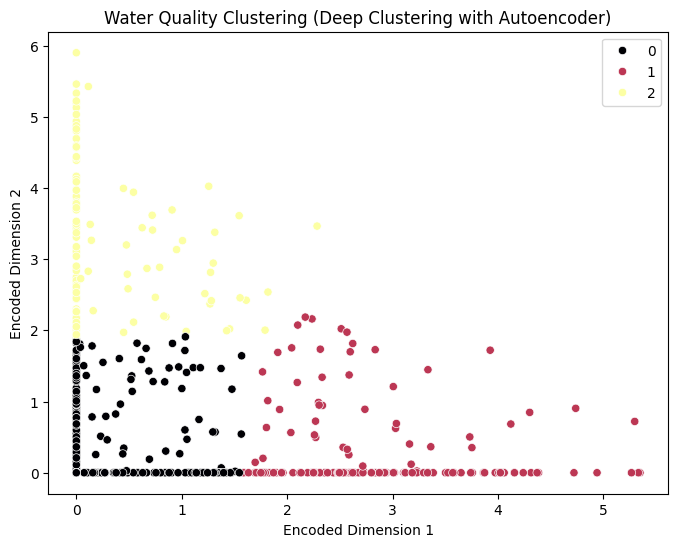

In [47]:
# simple cluster visualization
plt.figure(figsize=(8, 6))
sns.scatterplot(x=encoded_data[:, 0], y=encoded_data[:, 1], hue=clusters, palette='inferno')
plt.title('Water Quality Clustering (Deep Clustering with Autoencoder)')
plt.xlabel('Encoded Dimension 1')
plt.ylabel('Encoded Dimension 2')
plt.show()

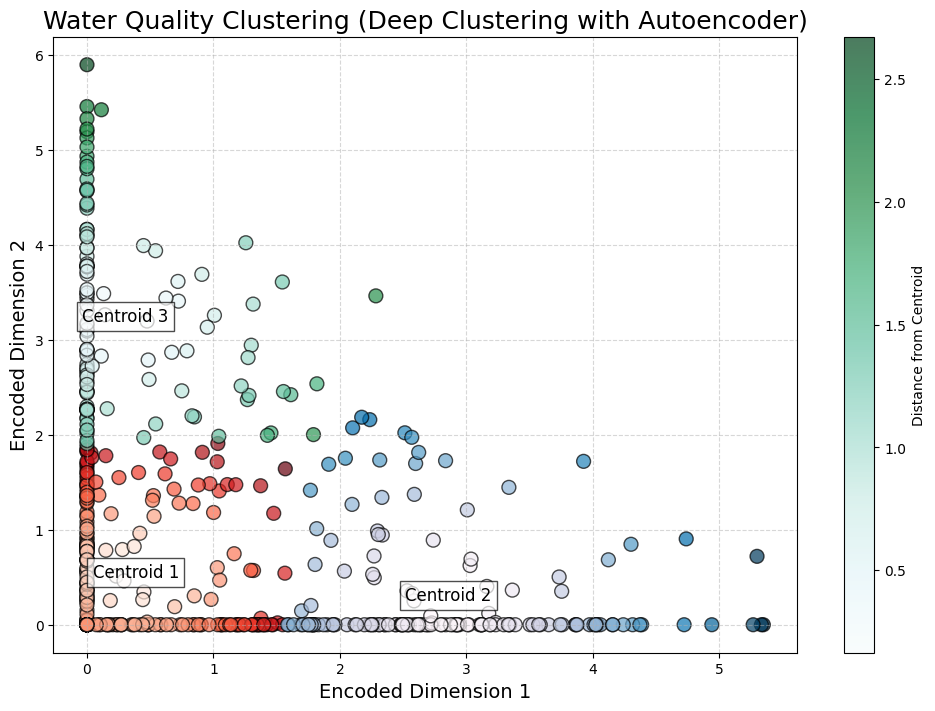

In [48]:
# more elaborate and descriptive custom visualization of clusters (takes distance from centroids into account)
plt.figure(figsize=(12, 8))
cluster_colors = ['Reds', 'PuBu', 'BuGn']

# for each cluster: gradient color mapping based on distance from centroid
for cluster in np.unique(clusters):
    cluster_data = encoded_data[clusters == cluster]
    centroid = centroids[cluster]

    distances = np.sqrt(np.sum((cluster_data - centroid) ** 2, axis=1))

    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], c=distances, cmap=cluster_colors[cluster], s=100, alpha=0.7, edgecolors='k', label=f'Cluster {cluster+1}')

for i, centroid in enumerate(centroids): # floating labels near centroids
    plt.text(centroid[0], centroid[1], f'Centroid {i+1}', fontsize=12, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.7))

plt.colorbar(label='Distance from Centroid')
plt.title('Water Quality Clustering (Deep Clustering with Autoencoder)', fontsize=18)
plt.xlabel('Encoded Dimension 1', fontsize=14)
plt.ylabel('Encoded Dimension 2', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
#plt.legend()
plt.show()

In [49]:
silhouette_avg = silhouette_score(encoded_data, clusters)
# evaluate clustering with silhouette score (between -1 t0 1). higher score = better-defined clusters
print(f'Silhouette Score: {silhouette_avg:.3f}')

Silhouette Score: 0.509


#### More about Silhouette Score:<br>
- +1: the samples are very well clustered. Cluster boundaries are well defined. The data points within a cluster are far from the neighboring clusters.
- 0: the samples are on or very close to the boundaries between clusters. It can be unclear which cluster data points belong to.
- -1: the samples are assigned to the wrong clusters. Many data points should rather have been assigned to different clusters.

In [50]:
df.to_csv('water_quality_data_clustered.csv', index=False)